**Go to working Directory**

In [1]:
cd "/content/drive/MyDrive/Colab Notebooks/de_ki_classifier"

/content/drive/MyDrive/Colab Notebooks/de_ki_classifier


**Preprocessing Step**

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
NUM_OF_SENTENCES = 200000
MAX_WORD_IN_SENTENCE = 15

def check_sentence(sentence):
    # if sentence contains only letters and punctuations, return True
    # else return False
    for ch in sentence:
        if ch.isalpha() == False and ch != "." and ch != "," and ch != "?" and ch != "!" and ch != " ":
            return False
    return True

def check_de_ki_suffix_v1(sentence):
    # if "de" is in the sentence add it to the file
    if " de " in sentence:
        if " ki " in sentence:
            return False
        return True

    # if "ki" is in the sentence add it to the file
    if " ki " in sentence:
        return True

    return False
def check_de_ki_suffix_v2(sentence):
    # check de and ki as a suffix
    # example: "alide", "oradaki", "bizde"

    # syllabicate
    for word in sentence.split():
        if word.endswith("de") or word.endswith("ki"):
            if len(word) > 2:
                return True

    return False

def write_separated_connected(sentence, f):
    # if de and ki is bağlaç, connect to the previous word
    # example "ali de bizde kaldı" -> "ali de biz de kaldı"

    # find the character of " de " or " ki " from the sentence
    ch = ""
    if " de " in sentence:
        ch = " de "
    elif " ki " in sentence:
        ch = " ki "
    else:
        return

    # replace " de " or " ki " with "de " or "ki "
    sentence_w = ""
    if ch == " de ":
        sentence_w = sentence.replace(ch, "de ")
    elif ch == " ki ":
        sentence_w = sentence.replace(ch, "ki ")

    # write the sentence to the file
    f.write(sentence_w + "\n")

# extract all sentences from the source file, write them to a new file
def extract_sentences(source_file, append = False, jump_size = 0):
    jump_size = 0
    line_limit = 15
    connected_limit = 9
    separated_filename = "separated_class.txt"
    not_separated_filename = "not_separated_class.txt"
    line_count = 0
    connected_count = 0
    count = 0

    mode = "w"
    if append:
        mode = "a"

    with open(source_file, "r") as f:
        with open(separated_filename, mode) as f2:
            with open(not_separated_filename, mode) as f3:
                for line in f:

                    if line.strip() != "":
                        # if (count > NUM_OF_SENTENCES):
                        #     break
                        # if line starts with < pass it,
                        # if line starts with align pass it
                        if line.startswith("<") or line.startswith("align"):
                            continue
                        sentences = nltk.sent_tokenize(line)

                        if (sentences == ""):
                            continue

                        # convert sentences array to sentences set
                        set_sentences = set(sentences)

                        for sentence in list(set_sentences):

                            # if length of sentence is more than 100, or less than 3, pass it
                            if len(sentence) > 70 or len(sentence) < 10:
                                continue

                            # if sentence has less than 3 words, pass it
                            if len(sentence.split()) < 3:
                                continue

                            # if sentence does not end with ".", "!", "?", pass it
                            if sentence.endswith(".") == False and sentence.endswith("!") == False and sentence.endswith("?") == False:
                                continue

                            # max word number is 7
                            if len(sentence.split()) > MAX_WORD_IN_SENTENCE:
                                continue

                            # convert to lowercase
                            sentence_w = sentence.lower()

                            # if sentence does not only contain letters and punctuations, pass it
                            if check_sentence(sentence_w) == False:
                                continue

                            # check if sentence includes "de" or "ki" suffix
                            if (check_de_ki_suffix_v1(sentence_w)):
                                count += 1
                                # f2.write(sentence_w + "\n")
                                write_separated_connected(sentence_w, f2)
                                line_count += 1

                            elif (check_de_ki_suffix_v2(sentence_w) and connected_count < connected_limit):
                                count += 1

                                # write as not separated
                                f3.write(sentence_w + "\n")
                                connected_count += 1
                                line_count += 1

                        if line_count > line_limit:
                            # jump 200 lines
                            # for i in range(jump_size):
                            #     f.readline()
                            line_count = 0
                            connected_count = 0

                        sentences.clear()


Add those files to the working directory.

In [4]:
extract_sentences("wiki.tr.txt", False)
extract_sentences("tr_corpus.txt", True)
extract_sentences("turkish_dump.txt", True)

**Training Step**

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization, SimpleRNN, Flatten, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


max_length = 16

In [3]:
def load_data():
  # load the data
  with open('separated_class.txt', 'r') as f:
      separated = f.read().split('\n')
  with open('not_separated_class.txt', 'r') as f:
      not_separated = f.read().split('\n')

  return separated, not_separated

def prepare_data():
  separated, not_separated = load_data()

  # prepare the sentences
  sentences = separated + not_separated

  # tokenize the sentences
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)

  # pad the sequences
  data = pad_sequences(sequences, maxlen=max_length)

  # convert labels to numpy arrays
  labels = np.array([1]*len(separated) + [0]*len(not_separated))

  return data, labels, tokenizer

def train_test_split_data():
  data, labels, tokenizer = prepare_data()

  # split data to test and train
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=42)

  return X_train, X_test, y_train, y_test, tokenizer


def train_classifier():

  # get model parameters
  X_train, X_test, y_train, y_test, tokenizer = train_test_split_data()

  vocab_size = len(tokenizer.word_index) + 1

  # define the model
  model = Sequential()
  model.add(Embedding(vocab_size, 32, input_length=max_length))
  # model.add(SimpleRNN(16, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), dropout=0.2, recurrent_dropout=0.2))
  model.add(Flatten())
  model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.5))
  # model.add(BatchNormalization())
  # model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

  model.summary()

  # define step size for adam optimizer
  c_adam = optimizers.Adam(learning_rate=0.001)

  # define sgd optimizer
  # c_sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

  # compile the model
  model.compile(loss='binary_crossentropy',
              optimizer= c_adam,
              metrics=['accuracy'])

  # define early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  # define model checkpoint
  model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

  # train the model with early stopping and model checkpoint
  history = model.fit(X_train, y_train,
              batch_size=64,
              epochs=100,
              validation_data=(X_test, y_test),
              callbacks=[early_stopping, model_checkpoint])

  # save the model to disk
  model.save('de_ki_model.keras')

  # save the tokenizer to disk
  with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  visualize_training(history)

**Visualization of Training**

In [4]:
def visualize_training(history):
  # Summarize history for accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  # Summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            5197568   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5205793 (19.86 MB)
Trainable params: 5205793 (19.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2754/2754 [==============================] - 38s 13ms/step - loss: 0.4423 - accuracy: 0.8501 - val_loss: 0.3540 - val_accuracy: 0.9008
E

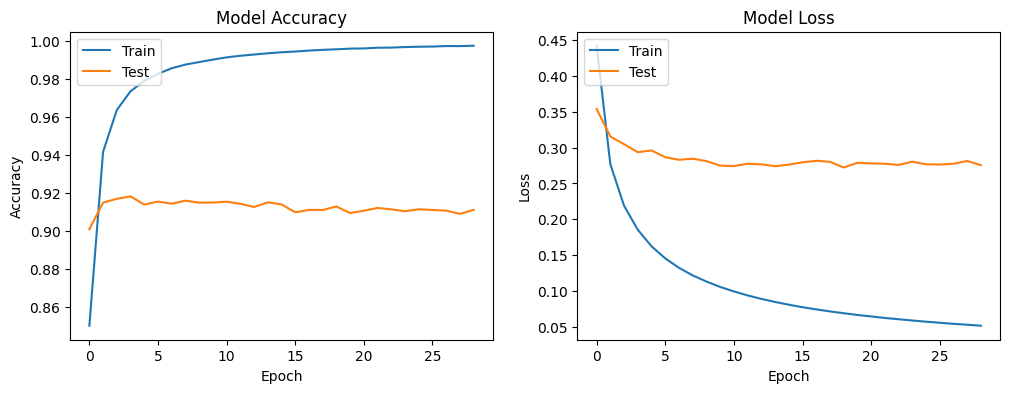

In [5]:
train_classifier()

**Prediction**

In [6]:
def load_classifier():
  # load the model from disk
  model = load_model('best_model.keras')

  # load the tokenizer from disk
  with open('tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)

  return model, tokenizer

In [7]:
def predict(sentence):
  model, tokenizer = load_classifier()

  # tokenize the sentence
  sequence = tokenizer.texts_to_sequences([sentence])

  # pad the sequence
  data = pad_sequences(sequence, maxlen=max_length)

  # use the model to predict the class
  prediction = model.predict(data)

  return prediction[0][0]

In [8]:
# read sentences from the file
def read_sentences_from_file(filename):
  sentences = []
  with open(filename, "r") as f:
    for line in f:
      sentences.append(line.strip())
  return sentences

def read_answers_from_file(filename):
  answers = []
  # written as "True" or "False"
  with open(filename, "r") as f:
    for line in f:
      answers.append(line.strip() == "True")
  return answers

In [9]:
# predict the sentences
def predict_sentences(sentences):
  predictions = []
  for sentence in sentences:
    predictions.append(predict(sentence))

  # set target values
  target = read_answers_from_file("answers.txt")

  correct_count = 0
  # print sentence, result value, result(True(Separated) or False(Not Separated)), target (True(Separated) or False(Not Separated)) as formatted
  for sentence, prediction, target_value in zip(sentences, predictions, target):
    result = prediction >= 0.5  # Adjust this threshold based on your preference
    print(f"Sentence: {sentence}")
    print(f"Classifier Output: {prediction}")
    print(f"Result: {result} ({'Separated' if result else 'Not Separated'})")
    print(f"Target: {target_value} ({'Separated' if target_value else 'Not Separated'})")
    print("=" * 50)

    # Check if the prediction is correct
    if result == target_value:
      correct_count += 1

  # Calculate and print correct classification percentage
  total_sentences = len(sentences)
  correct_percentage = (correct_count / total_sentences) * 100
  print(f"Correct Classification Percentage: {correct_percentage:.2f}%")


In [10]:
predict_filename = "test_sentences.txt"
predict_sentences(read_sentences_from_file(predict_filename))

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 49ms/step
Sentence: okulumuzun öğrencilerinde gelişme var.
Classifier Output: 0.014484201557934284
Result: False (Not Separated)
Target: False (Not Separated)
Sentence: toplu yemek etkinliğine öğrencilerde geldi.
Classifier Output: 0.9979123473167419
Result: True (Separated)
Target: True (Separated)
Sentence: oradaki eve ne olduğunu bilmiyorum.
Classifier Output: 0.06613121926784515
Result: False (Not Separated)
Target: False (Not Separated)
Sentence: durumun kendiside farkında değil.
Classifier Output: 0.9983834028244019
Result: True (Separated)
Target: True (Separated)
Sentence: o kadar saat baktık, halbuki hemen çözülebilirmiş.
Classifier Output: 0.026547400280833244
Result: False (Not Separated)
Target: False (Not Separated)
Sentence: nerede kalacağımıza henüz karar vermedik.
Classifier Output: 0.20078358054161072
Result: False (Not Separated)
Target: False (Not Separated)
Sentence: yeterince çabalamadıkki sonuç istediğimiz gibi olsun.
Clas